In [1]:
from collections import OrderedDict
from glob import glob
from osgeo import gdal; gdal.UseExceptions()
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def read_tiff(file):
    ds = gdal.Open(file)
    arr = ds.ReadAsArray()
    arr = (arr - arr.min()) / (arr.max() - arr.min()) * 255

    arr = arr.astype(float)
    # to gray scale
    arr = arr.mean(axis=0)
    return arr

In [2]:
# calculate PSNR/SSIM and NDVI for nine models

# reference HR image
REF = '../datasets/RAW/NAIP_TEST_2020.tif'
# paths to the nine models
MODELS = glob('../experiments/final/*PL_TEST*/img.tif')
MODELS.sort()

MODELS.insert(0, '../experiments/final/rgbir_naip2naip_25_128_sb_1.00_NAIP_TEST_250126_174514/img.tif')
MODELS.insert(0, '../datasets/RAW/NAIP_TEST_SR_2020.tif')
MODELS.insert(0, '../datasets/RAW/PL_TEST_SR_Aligned_2020.tif')

MODELS

['../datasets/RAW/PL_TEST_SR_Aligned_2020.tif',
 '../datasets/RAW/NAIP_TEST_SR_2020.tif',
 '../experiments/final/rgbir_naip2naip_25_128_sb_1.00_NAIP_TEST_250126_174514/img.tif',
 '../experiments/final/rgbir_naip2naip_25_128_sb_1.00_PL_TEST_250112_001529/img.tif',
 '../experiments/final/rgbir_pl2naip_25_128_sb_0.25_PL_TEST_250113_072853/img.tif',
 '../experiments/final/rgbir_pl2naip_25_128_sb_0.50_PL_TEST_250119_221437/img.tif',
 '../experiments/final/rgbir_pl2naip_25_128_sb_0.75_PL_TEST_250118_133908/img.tif',
 '../experiments/final/rgbir_pl2naip_25_128_sb_1.00_PL_TEST_250118_133723/img.tif',
 '../experiments/final/rgbir_pl2naip_finetune_25_128_sb_0.25_PL_TEST_250118_133559/img.tif',
 '../experiments/final/rgbir_pl2naip_finetune_25_128_sb_0.50_PL_TEST_250118_133120/img.tif',
 '../experiments/final/rgbir_pl2naip_finetune_25_128_sb_0.75_PL_TEST_250112_002042/img.tif',
 '../experiments/final/rgbir_pl2naip_finetune_25_128_sb_1.00_PL_TEST_250112_001204/img.tif']

In [3]:
def cal_metrics(ref, sr):
    # calculate PSNR
    psnr = peak_signal_noise_ratio(ref, sr, data_range=255)

    # calculate SSIM
    ssim = structural_similarity(ref, sr, data_range=255)

    # calculate MSE
    mse = ((ref - sr) ** 2).mean()

    return {'PSNR': psnr, 'SSIM': ssim, 'MSE': mse}


def ols(ref, sr, verbose=False):
    results = smf.ols('y ~ x', data=pd.DataFrame({'y': ref.flatten(), 'x': sr.flatten()})).fit()
    if verbose:
        print(results.summary())
    return {'R2': results.rsquared, 'p-value': results.f_pvalue}


def ols_map(ref, sr, patch_size=(128, 128)):
    h, w = ref.shape
    patch_h, patch_w = patch_size

    # trim ref and sr to be multiples of patch_h and patch_w
    h = h - h % patch_h
    w = w - w % patch_w
    ref = ref[:h, :w]
    sr = sr[:h, :w]

    r2_map = np.zeros((h // patch_h, w // patch_w))

    for i in range(0, h, patch_h):
        for j in range(0, w, patch_w):
            patch_ref = ref[i:i+patch_h, j:j+patch_w]
            patch_sr = sr[i:i+patch_h, j:j+patch_w]

            ols_result = ols(patch_ref, patch_sr)
            r2_map[i // patch_h, j // patch_w] = ols_result['R2']

    average_r2 = np.mean(r2_map)
    plt.imshow(r2_map, cmap='jet')
    plt.colorbar()
    plt.show()
    return {'average R2': average_r2}



Processing model:  ../datasets/RAW/PL_TEST_SR_Aligned_2020.tif
Reference shape:  (12460, 10470) SR shape:  (12460, 10470)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                 1.637e+08
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:41:14   Log-Likelihood:            -5.9843e+08
No. Observations:           130456200   AIC:                         1.197e+09
Df Residuals:               130456198   BIC:                         1.197e+09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

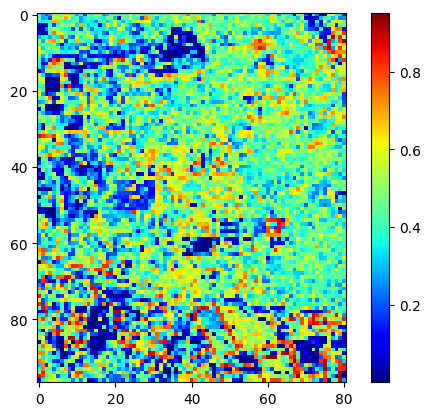

OrderedDict({'model': '../datasets/RAW/PL_TEST_SR_Aligned_2020.tif', 'PSNR': np.float64(5.788775602338248), 'SSIM': np.float64(0.0797322353751527), 'MSE': np.float64(17147.578537105222), 'R2': np.float64(0.5565362183292786), 'p-value': np.float64(0.0), 'average R2': np.float64(0.4144869737542834)})

 

--------------------------------------------------
Processing model:  ../datasets/RAW/NAIP_TEST_SR_2020.tif
Reference shape:  (12460, 10470) SR shape:  (12460, 10470)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 1.248e+09
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:43:12   Log-Likelihood:            -4.9766e+08
No. Observations:           130456200   AIC:           

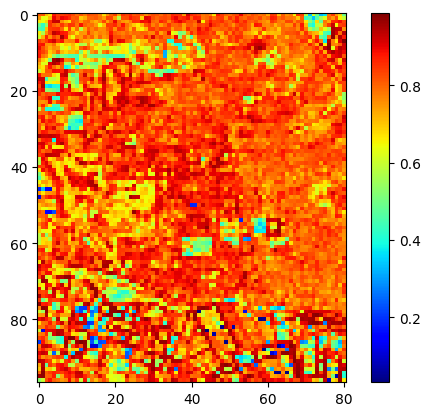

OrderedDict({'model': '../datasets/RAW/NAIP_TEST_SR_2020.tif', 'PSNR': np.float64(27.280471779391476), 'SSIM': np.float64(0.715749280786231), 'MSE': np.float64(121.62789287329467), 'R2': np.float64(0.9053897842247205), 'p-value': np.float64(0.0), 'average R2': np.float64(0.7848461547088453)})

 

--------------------------------------------------
Processing model:  ../experiments/final/rgbir_naip2naip_25_128_sb_1.00_NAIP_TEST_250126_174514/img.tif
Reference shape:  (12416, 10368) SR shape:  (12416, 10368)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                 2.607e+08
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:45:08   Log-Likelihood:            -5.7177e+08
No. Observation

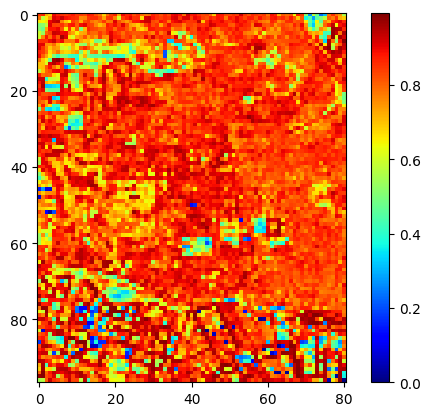

OrderedDict({'model': '../experiments/final/rgbir_naip2naip_25_128_sb_1.00_NAIP_TEST_250126_174514/img.tif', 'PSNR': np.float64(20.139811723702145), 'SSIM': np.float64(0.6673141558853658), 'MSE': np.float64(629.6499721661143), 'R2': np.float64(0.6694632551774542), 'p-value': np.float64(0.0), 'average R2': np.float64(0.7989068590564754)})

 

--------------------------------------------------
Processing model:  ../experiments/final/rgbir_naip2naip_25_128_sb_1.00_PL_TEST_250112_001529/img.tif
Reference shape:  (12416, 10368) SR shape:  (12416, 10368)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                 8.525e+07
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:47:03   Log-Likeli

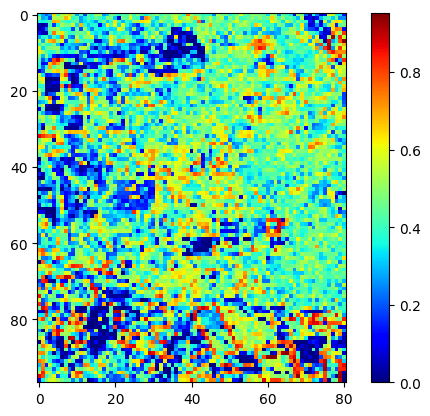

OrderedDict({'model': '../experiments/final/rgbir_naip2naip_25_128_sb_1.00_PL_TEST_250112_001529/img.tif', 'PSNR': np.float64(13.072127515283187), 'SSIM': np.float64(0.4697150252206203), 'MSE': np.float64(3205.2920718850496), 'R2': np.float64(0.39841280193112505), 'p-value': np.float64(0.0), 'average R2': np.float64(0.4147997014891477)})

 

--------------------------------------------------
Processing model:  ../experiments/final/rgbir_pl2naip_25_128_sb_0.25_PL_TEST_250113_072853/img.tif
Reference shape:  (12416, 10368) SR shape:  (12416, 10368)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                 6.215e+07
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:48:59   Log-Likeliho

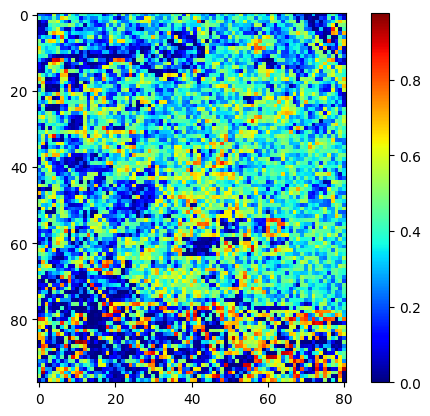

OrderedDict({'model': '../experiments/final/rgbir_pl2naip_25_128_sb_0.25_PL_TEST_250113_072853/img.tif', 'PSNR': np.float64(15.552582915335433), 'SSIM': np.float64(0.36928014347466437), 'MSE': np.float64(1810.598137681147), 'R2': np.float64(0.3255990785631162), 'p-value': np.float64(0.0), 'average R2': np.float64(0.3521932566115983)})

 

--------------------------------------------------
Processing model:  ../experiments/final/rgbir_pl2naip_25_128_sb_0.50_PL_TEST_250119_221437/img.tif
Reference shape:  (12416, 10368) SR shape:  (12416, 10368)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                 6.376e+07
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:51:01   Log-Likelihood:

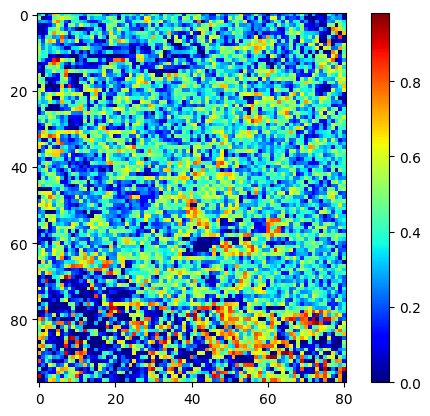

OrderedDict({'model': '../experiments/final/rgbir_pl2naip_25_128_sb_0.50_PL_TEST_250119_221437/img.tif', 'PSNR': np.float64(15.808090164164044), 'SSIM': np.float64(0.35985149646666253), 'MSE': np.float64(1707.148671581491), 'R2': np.float64(0.3312406158775206), 'p-value': np.float64(0.0), 'average R2': np.float64(0.3511974098780332)})

 

--------------------------------------------------
Processing model:  ../experiments/final/rgbir_pl2naip_25_128_sb_0.75_PL_TEST_250118_133908/img.tif
Reference shape:  (12416, 10368) SR shape:  (12416, 10368)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                 4.687e+07
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:53:00   Log-Likelihood:

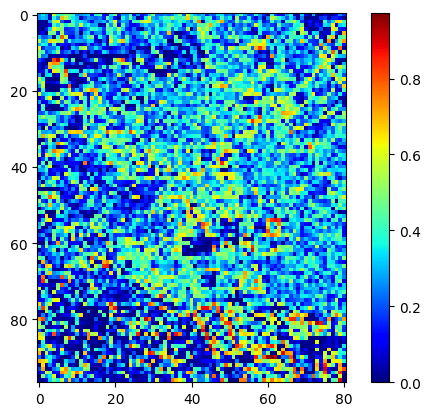

OrderedDict({'model': '../experiments/final/rgbir_pl2naip_25_128_sb_0.75_PL_TEST_250118_133908/img.tif', 'PSNR': np.float64(16.037033219152516), 'SSIM': np.float64(0.3860990073605043), 'MSE': np.float64(1619.485406878184), 'R2': np.float64(0.2669341883277454), 'p-value': np.float64(0.0), 'average R2': np.float64(0.2966234276065286)})

 

--------------------------------------------------
Processing model:  ../experiments/final/rgbir_pl2naip_25_128_sb_1.00_PL_TEST_250118_133723/img.tif
Reference shape:  (12416, 10368) SR shape:  (12416, 10368)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                 6.365e+07
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:55:09   Log-Likelihood: 

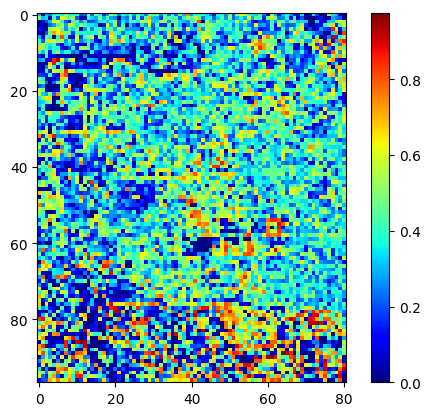

OrderedDict({'model': '../experiments/final/rgbir_pl2naip_25_128_sb_1.00_PL_TEST_250118_133723/img.tif', 'PSNR': np.float64(16.846488173906774), 'SSIM': np.float64(0.4206691785200966), 'MSE': np.float64(1344.0998835820308), 'R2': np.float64(0.33087290340151765), 'p-value': np.float64(0.0), 'average R2': np.float64(0.3655183108752556)})

 

--------------------------------------------------
Processing model:  ../experiments/final/rgbir_pl2naip_finetune_25_128_sb_0.25_PL_TEST_250118_133559/img.tif
Reference shape:  (12416, 10368) SR shape:  (12416, 10368)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                 5.758e+07
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:57:04   Log-L

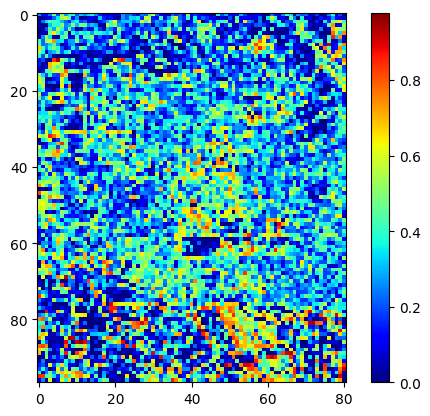

OrderedDict({'model': '../experiments/final/rgbir_pl2naip_finetune_25_128_sb_0.25_PL_TEST_250118_133559/img.tif', 'PSNR': np.float64(16.527081686220434), 'SSIM': np.float64(0.37719017708564284), 'MSE': np.float64(1446.679049827421), 'R2': np.float64(0.3090497943020002), 'p-value': np.float64(0.0), 'average R2': np.float64(0.31673479709449115)})

 

--------------------------------------------------
Processing model:  ../experiments/final/rgbir_pl2naip_finetune_25_128_sb_0.50_PL_TEST_250118_133120/img.tif
Reference shape:  (12416, 10368) SR shape:  (12416, 10368)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                 6.894e+07
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:59:0

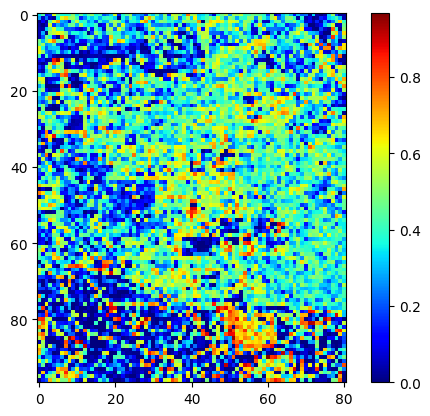

OrderedDict({'model': '../experiments/final/rgbir_pl2naip_finetune_25_128_sb_0.50_PL_TEST_250118_133120/img.tif', 'PSNR': np.float64(16.287099771722076), 'SSIM': np.float64(0.37124566389627756), 'MSE': np.float64(1528.8693833240213), 'R2': np.float64(0.34875250248141854), 'p-value': np.float64(0.0), 'average R2': np.float64(0.353577558138415)})

 

--------------------------------------------------
Processing model:  ../experiments/final/rgbir_pl2naip_finetune_25_128_sb_0.75_PL_TEST_250112_002042/img.tif
Reference shape:  (12416, 10368) SR shape:  (12416, 10368)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                 6.332e+07
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:00:5

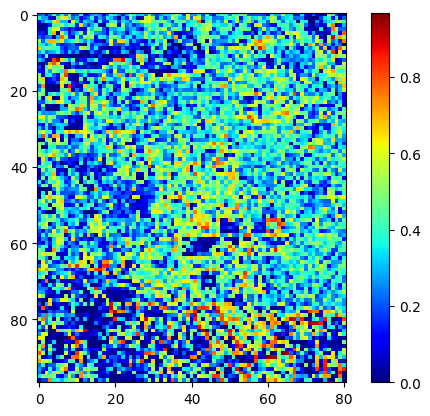

OrderedDict({'model': '../experiments/final/rgbir_pl2naip_finetune_25_128_sb_0.75_PL_TEST_250112_002042/img.tif', 'PSNR': np.float64(16.010622020084476), 'SSIM': np.float64(0.3437655194490467), 'MSE': np.float64(1629.3641587096), 'R2': np.float64(0.3297056496756563), 'p-value': np.float64(0.0), 'average R2': np.float64(0.3334921633389518)})

 

--------------------------------------------------
Processing model:  ../experiments/final/rgbir_pl2naip_finetune_25_128_sb_1.00_PL_TEST_250112_001204/img.tif
Reference shape:  (12416, 10368) SR shape:  (12416, 10368)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                 5.480e+07
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:03:05   

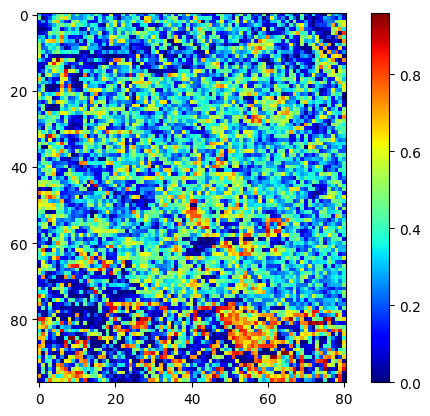

OrderedDict({'model': '../experiments/final/rgbir_pl2naip_finetune_25_128_sb_1.00_PL_TEST_250112_001204/img.tif', 'PSNR': np.float64(15.898713164864493), 'SSIM': np.float64(0.3814896954741135), 'MSE': np.float64(1671.8951748245408), 'R2': np.float64(0.29857503844217903), 'p-value': np.float64(0.0), 'average R2': np.float64(0.34128194474620416)})

 

--------------------------------------------------


,model,PSNR,SSIM,MSE,R2,p-value,average R2
0,../datasets/RAW/PL_TEST_SR_Aligned_2020.tif,5.788776,0.079732,17147.578537,0.556536,0.0,0.414487
1,../datasets/RAW/NAIP_TEST_SR_2020.tif,27.280472,0.715749,121.627893,0.905390,0.0,0.784846
2,../experiments/final/rgbir_naip2naip_25_128_sb...,20.139812,0.667314,629.649972,0.669463,0.0,0.798907
3,../experiments/final/rgbir_naip2naip_25_128_sb...,13.072128,0.469715,3205.292072,0.398413,0.0,0.414800
4,../experiments/final/rgbir_pl2naip_25_128_sb_0...,15.552583,0.369280,1810.598138,0.325599,0.0,0.352193
5,../experiments/final/rgbir_pl2naip_25_128_sb_0...,15.808090,0.359851,1707.148672,0.331241,0.0,0.351197
6,../experiments/final/rgbir_pl2naip_25_128_sb_0...,16.037033,0.386099,1619.485407,0.266934,0.0,0.296623
7,../experiments/final/rgbir_pl2naip_25_128_sb_1...,16.846488,0.420669,1344.099884,0.330873,0.0,0.365518
8,../experiments/final/rgbir_pl2naip_finetune_25...,16.527082,0.377190,1446.679050,0.309050,0.0,0.316735
9,../experiments/final/rgbir_pl2naip_finetune_25...,16.287100,0.371246,1528.869383,0.348753,0.0,0.353578


In [4]:
reference = read_tiff(REF)


report = []
for model_path in MODELS:
    sr = read_tiff(model_path)
    # align the size of reference and sr
    reference_crop = reference[0:sr.shape[0], 0:sr.shape[1]]

    print("Processing model: ", model_path)
    print("Reference shape: ", reference_crop.shape, "SR shape: ", sr.shape)
    metrics = OrderedDict({'model': model_path})
    metrics.update(cal_metrics(reference_crop, sr))
    metrics.update(ols(reference_crop, sr, verbose=True))
    metrics.update(ols_map(reference_crop, sr))
    report.append(metrics)
    print(metrics)
    print('\n \n')
    print("-" * 50)


df = pd.DataFrame(report)
df.to_csv('metrics.csv', index=False)
df